In [2]:
import os
import copy
import pickle
import numpy as np
import glob

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# astropy
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.coordinates import SkyCoord, Angle
from astropy import wcs
from astropy.table import Table,vstack
import astropy.units as u
import matplotlib.pyplot as plt 
import sncosmo 

from candels_galaxy_surveys import galaxy_catalog,galaxy_survey

alexsev & augustus are likely not Ia's based  on stardust prob from paper https://arxiv.org/pdf/1310.3495.pdf; they are not fitted for the moment. 

nero not fit because there are only two data points and they are both just values of flux = 0

The others are modeled with salt2 as Ia fit to data from WFC3 IR wide band filters:

cla10cal and geta to f125w,f160w
caracalla and didius using f105w, f110w, f140w, f160w
rose using f160w, f110w
tiberius using f105w, f125w, f160w

from previous iteration...
the mw dust extinction is used with map value provided 
the redshift is bounded using value/errors given

The results are in the folder clashIa in this directory. pkl files which contain the data table, [result, fitted_model], figure for fitted bands.

I'll upload a pdf of piece of this nb so code is visible for one of them. Then jpegs of the figs that result for fitted bands. 

In [3]:
# 4. The lcs, sncosmo friendly tables
with open(r'C:/Users/Kyle/Documents/sn/work/lightcurves/data/clashlc.pkl', 'rb') as f:
    clashlc = pickle.load(f)
with open(r'C:/Users/Kyle/Documents/sn/work/lightcurves/data/goodsnlc', 'rb') as f:
    goodsnlc = pickle.load(f)
with open(r'C:/Users/Kyle/Documents/sn/work/lightcurves/data/udslc', 'rb') as f:
    udslc = pickle.load(f)
with open(r'C:/Users/Kyle/Documents/sn/work/lightcurves/data/egslc', 'rb') as f:
    egslc = pickle.load(f)
with open(r'C:/Users/Kyle/Documents/sn/work/lightcurves/data/goodsslc', 'rb') as f:
    goodsslc = pickle.load(f)
with open(r'C:/Users/Kyle/Documents/sn/work/lightcurves/data/coslc', 'rb') as f:
    coslc = pickle.load(f)
lcs = coslc + egslc + goodsnlc + goodsslc + udslc + clashlc

In [4]:
for i in range(len(clashlc)):
    print(i,clashlc[i].meta['NICKNAME'])    

0 ['alexsev']
1 ['augustus']
2 ['CLA10Cal']
3 ['caracalla']
4 ['caracalla2']
5 ['caracalla3']
6 ['Caracalla4']
7 ['caracallaS']
8 ['didius']
9 ['geta']
10 ['geta2']
11 ['nero']
12 ['nero2']
13 ['rose']
14 ['Tiberius']
15 ['tiberius2']
16 ['tiberius3']
17 ['tiberius4']
18 ['TiberiusPK']


CLA10Cal
11 including dust
success


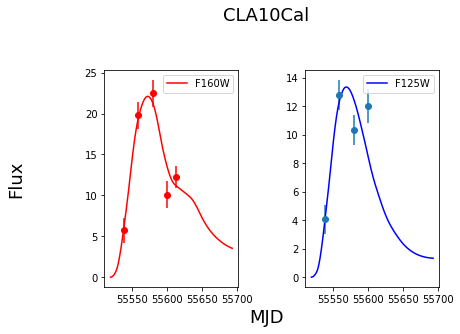

In [5]:
# To append the result,fitted model, data too
lightcurve_model = []

# CLA10Cal; starudust 0.95 probability of Ia
i = 2
tab = clashlc[i]
name = clashlc[i].meta['NICKNAME'][0]
print(name)
model = sncosmo.Model(source='salt2')
lightcurve_model.append(tab)

# Only fit to these bands
dat = copy.copy(tab)
tmp = list(np.arange(len(dat)))
for i in range(len(dat)):
    if dat[i]['band'] == 'F160W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F125W':
        tmp.remove(i)
    else: continue
dat.remove_rows(tmp)

# using initial redshift and bounds from previous fits available in table
try:
    z = np.float(tab.meta['REDSHIFT_FINAL'][0])
    dz = np.float(tab.meta['REDSHIFT_FINAL'][2])
    zup = z + dz
    zlow = z - dz
except:
    pass

# include the dust extinction for lights path through milky way
model.add_effect(sncosmo.CCM89Dust(),'mw','obs')
try:
    ebv = np.float(tab.meta['MWEBV'][0])
    model.set(mwebv = ebv)
    print(i,'including dust')
except: pass

# try to fit model
try:
    result,fitted_model=sncosmo.fit_lc(
        dat ,model,
        ['z', 't0', 'x0', 'x1', 'c'],
        bounds={'z':(zlow,zup)})
    print('success')
except:
    [result,fitted_model] = ['failed','failed'] 
    print('failed')
    
# put results and fitted_model into list object with astropy table of data 
lightcurve_model.append([result,fitted_model])
    

# Remaining is just plotting... using model to display the fit w data
# need the f160w and f125w data points/error bars to plot with model  
f160w = []
f125w = []
for i in dat:
    if i['band'] == 'F160W':
        f160w.append(i)
    elif i['band'] == 'F125W':
        f125w.append(i)
    else: print('not f125 or f160? should only have these remaining')
from astropy.table import vstack
f160w = vstack([i for i in  f160w])
f125w = vstack([i for i in f125w])
flux_f160w = [i for i in f160w['flux']] 
flux_f125w = [i for i in f125w['flux']]
dflux_f160w = [i for i in  f160w['fluxerr']]
dflux_f125w = [i for i in f125w['fluxerr']]
t160w = [i for i in f160w['time']]
t125w = [i for i in f125w['time']]


z = fitted_model.parameters[0]
t0 = fitted_model.parameters[1]
x1 = fitted_model.parameters[2]
x2 = fitted_model.parameters[3]
c = fitted_model.parameters[4]

# may need to play with these to get plot looking good for each different case
t = np.linspace(t0 - 50,t0+125,10000)
fig, (ax1,ax2) = plt.subplots(1,2)
fig.text(0.5, 0.001, 'MJD', ha='center',size=18)
fig.text(-0.1, 0.5, 'Flux', va='center', rotation='vertical',size=18)
#txtstr = 'z =' + str(z)[:4] + '\n' 't0 = '+ str(t0)[:7] + '\n' + 'A = '+ str(np.format_float_scientific(A,precision=2))
#fig.text(.5,1.10,txtstr,va='center',size=18)

fig.text(0.4,1.05,name,size=18)


ax1.plot(t,fitted_model.bandflux('F160W',t,zp=27.5,zpsys='VEGA'),label='F160W',color = 'red')
ax1.errorbar(t160w,flux_f160w,yerr = dflux_f160w,fmt='o',color='red')

ax2.plot(t,fitted_model.bandflux('F125W',t,zp=27.5,zpsys='VEGA'),label='F125W',color='blue')
ax2.errorbar(t125w,flux_f125w,yerr=dflux_f125w,fmt='o')

plt.subplots_adjust(wspace=0.5)
ax1.legend()
ax2.legend()

# saves jpeg
#img_jpeg = plt.savefig(name,bbox_inches='tight')
# dumps the fig into pickle; nice if want to play with figure later
# img_pkl = pickle.dump(fig, open(name+'.pkl', 'wb'))
# %matplotlib notebook
# load_img_pkl = pickle.load( open( "CLA10Cal.pkl", "rb" ) )
pickle.dump(lightcurve_model,open('results/clashIa_sansfig/'+name+'sansfig.pkl','wb'))

# include an image with the data table, result, fit 
lightcurve_model.append(fig)

pickle.dump(lightcurve_model,open(name+'.pkl','wb'))
# view in another notebook = pickle.load(open('CLA10Cal.pkl','rb'))

caracalla
14 including dust
success


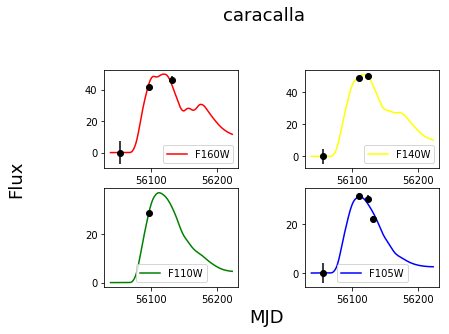

In [6]:
# To append the result,fitted model, data too
lightcurve_model = []

# CL012Car; caracalla Ia
i = 3
tab = clashlc[i]
name = clashlc[i].meta['NICKNAME'][0]
print(name)
model = sncosmo.Model(source='salt2')
lightcurve_model.append(tab)

# Only fit to these nir bands
dat = copy.copy(tab)
tmp = list(np.arange(len(dat)))
for i in range(len(dat)):
    if dat[i]['band'] == 'F160W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F110W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F105W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F140W':
        tmp.remove(i)
    else: continue
dat.remove_rows(tmp)

# using initial redshift and bounds from previous fits available in table
try:
    z = np.float(tab.meta['REDSHIFT_FINAL'][0])
    dz = np.float(tab.meta['REDSHIFT_FINAL'][2])
    zup = z + dz
    zlow = z - dz
except:
    pass

# include the dust extinction for lights path through milky way
model.add_effect(sncosmo.CCM89Dust(),'mw','obs')
try:
    ebv = np.float(tab.meta['MWEBV'][0])
    model.set(mwebv = ebv)
    print(i,'including dust')
except: pass

# try to fit model
try:
    result,fitted_model=sncosmo.fit_lc(
        dat ,model,
        ['z', 't0', 'x0', 'x1', 'c'],
        bounds={'z':(zlow,zup)})
    print('success')
except:
    [result,fitted_model] = ['failed','failed'] 
    print('failed')
    
# put results and fitted_model into list object with astropy table of data 
lightcurve_model.append([result,fitted_model])
    

# Remaining is just plotting... using model to display the fit w data
# need the nir data points/error bars to plot with model  
f160w = []
f110w = []
f105w = []
f140w = []
for i in dat:
    if i['band'] == 'F160W':
        f160w.append(i)
    elif i['band'] == 'F110W':
        f110w.append(i)
    elif i['band'] == 'F105W':
        f105w.append(i)
    elif i['band'] == 'F140W':
        f140w.append(i)
    else: print('not one of the bands that should be remaining')

from astropy.table import vstack
f160w = vstack([i for i in  f160w])
f110w = vstack([i for i in f110w])
f105w = vstack([i for i in f105w])
f140w = vstack([i for i in f140w])

flux_f160w = [i for i in f160w['flux']] 
flux_f110w = [i for i in f110w['flux']]
flux_f105w = [i for i in f105w['flux']]
flux_f140w = [i for i in f140w['flux']]


dflux_f160w = [i for i in  f160w['fluxerr']]
dflux_f110w = [i for i in f110w['fluxerr']]
dflux_f105w = [i for i in f105w['fluxerr']]
dflux_f140w = [i for i in f140w['fluxerr']]


t160w = [i for i in f160w['time']]
t110w = [i for i in f110w['time']]
t105w = [i for i in f105w['time']]
t140w = [i for i in f140w['time']]


z = fitted_model.parameters[0]
t0 = fitted_model.parameters[1]
x1 = fitted_model.parameters[2]
x2 = fitted_model.parameters[3]
c = fitted_model.parameters[4]

# may need to play with time to get plot looking good for each different case
t = np.linspace(t0 - 75,t0+110,10000)

fig, axes = plt.subplots(2,2)
fig.text(0.5, 0.001, 'MJD', ha='center',size=18)
fig.text(-0.1, 0.5, 'Flux', va='center', rotation='vertical',size=18)
#txtstr = 'z =' + str(z)[:4] + '\n' 't0 = '+ str(t0)[:7] + '\n' + 'A = '+ str(np.format_float_scientific(A,precision=2))
#fig.text(.5,1.10,txtstr,va='center',size=18)

fig.text(0.4,1.05,name,size=18)


axes[0,0].plot(t,fitted_model.bandflux('F160W',t,zp=27.5,zpsys='VEGA'),label='F160W',color = 'red')
axes[0,0].errorbar(t160w,flux_f160w,yerr = dflux_f160w,fmt='o',color='black')

axes[0,1].plot(t,fitted_model.bandflux('F140W',t,zp=27.5,zpsys='VEGA'),label='F140W',color='yellow')
axes[0,1].errorbar(t140w,flux_f140w,yerr=dflux_f140w,fmt='o',color='black')

axes[1,0].plot(t,fitted_model.bandflux('F110W',t,zp=27.5,zpsys='VEGA'),label='F110W',color='green')
axes[1,0].errorbar(t110w,flux_f110w,yerr=dflux_f110w,fmt='o',color='black')

axes[1,1].plot(t,fitted_model.bandflux('F105W',t,zp=27.5,zpsys='VEGA'),label='F105W',color='blue')
axes[1,1].errorbar(t105w,flux_f105w,yerr=dflux_f105w,fmt='o',color='black')



plt.subplots_adjust(wspace=0.5)
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
# saves jpeg
#img_jpeg = plt.savefig(name,bbox_inches='tight')
# dumps the fig into pickle; nice if want to play with figure later
# img_pkl = pickle.dump(fig, open(name+'.pkl', 'wb'))
# %matplotlib notebook
# load_img_pkl = pickle.load( open( "CLA10Cal.pkl", "rb" ) )

pickle.dump(lightcurve_model,open('results/clashIa_sansfig/'+name+'sansfig.pkl','wb'))

# include an image with the data table, result, fit 
lightcurve_model.append(fig)

pickle.dump(lightcurve_model,open(name+'.pkl','wb'))
# view in another notebook = pickle.load(open('name.pkl','rb'))

didius
23 including dust
success


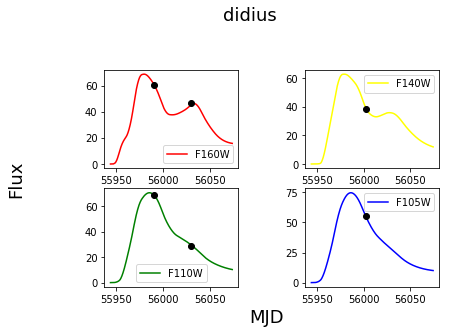

In [7]:
# To append the result,fitted model, data too
lightcurve_model = []

# CLN12Did; didius Ia
i = 8
tab = clashlc[i]
name = clashlc[i].meta['NICKNAME'][0]
print(name)
model = sncosmo.Model(source='salt2')
lightcurve_model.append(tab)

# Only fit to these nir bands
dat = copy.copy(tab)
tmp = list(np.arange(len(dat)))
for i in range(len(dat)):
    if dat[i]['band'] == 'F160W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F110W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F105W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F140W':
        tmp.remove(i)
    else: continue
dat.remove_rows(tmp)

# using initial redshift and bounds from previous fits available in table
try:
    z = np.float(tab.meta['REDSHIFT_FINAL'][0])
    dz = np.float(tab.meta['REDSHIFT_FINAL'][2])
    zup = z + dz
    zlow = z - dz
except:
    pass

# include the dust extinction for lights path through milky way
model.add_effect(sncosmo.CCM89Dust(),'mw','obs')
try:
    ebv = np.float(tab.meta['MWEBV'][0])
    model.set(mwebv = ebv)
    print(i,'including dust')
except: pass

# try to fit model
try:
    result,fitted_model=sncosmo.fit_lc(
        dat ,model,
        ['z', 't0', 'x0', 'x1', 'c'],
        bounds={'z':(zlow,zup)})
    print('success')
except:
    [result,fitted_model] = ['failed','failed'] 
    print('failed')
    
# put results and fitted_model into list object with astropy table of data 
lightcurve_model.append([result,fitted_model])
    

# Remaining is just plotting... using model to display the fit w data
# need the nir data points/error bars to plot with model  
f160w = []
f110w = []
f105w = []
f140w = []
for i in dat:
    if i['band'] == 'F160W':
        f160w.append(i)
    elif i['band'] == 'F110W':
        f110w.append(i)
    elif i['band'] == 'F105W':
        f105w.append(i)
    elif i['band'] == 'F140W':
        f140w.append(i)
    else: print('not one of the bands that should be remaining')

from astropy.table import vstack
f160w = vstack([i for i in  f160w])
f110w = vstack([i for i in f110w])
f105w = vstack([i for i in f105w])
f140w = vstack([i for i in f140w])

flux_f160w = [i for i in f160w['flux']] 
flux_f110w = [i for i in f110w['flux']]
flux_f105w = [i for i in f105w['flux']]
flux_f140w = [i for i in f140w['flux']]


dflux_f160w = [i for i in  f160w['fluxerr']]
dflux_f110w = [i for i in f110w['fluxerr']]
dflux_f105w = [i for i in f105w['fluxerr']]
dflux_f140w = [i for i in f140w['fluxerr']]


t160w = [i for i in f160w['time']]
t110w = [i for i in f110w['time']]
t105w = [i for i in f105w['time']]
t140w = [i for i in f140w['time']]


z = fitted_model.parameters[0]
t0 = fitted_model.parameters[1]
x1 = fitted_model.parameters[2]
x2 = fitted_model.parameters[3]
c = fitted_model.parameters[4]

# may need to play with time to get plot looking good for each different case
t = np.linspace(t0 - 40,t0+90,10000)

fig, axes = plt.subplots(2,2)
fig.text(0.5, 0.001, 'MJD', ha='center',size=18)
fig.text(-0.1, 0.5, 'Flux', va='center', rotation='vertical',size=18)
#txtstr = 'z =' + str(z)[:4] + '\n' 't0 = '+ str(t0)[:7] + '\n' + 'A = '+ str(np.format_float_scientific(A,precision=2))
#fig.text(.5,1.10,txtstr,va='center',size=18)

fig.text(0.4,1.05,name,size=18)


axes[0,0].plot(t,fitted_model.bandflux('F160W',t,zp=27.5,zpsys='VEGA'),label='F160W',color = 'red')
axes[0,0].errorbar(t160w,flux_f160w,yerr = dflux_f160w,fmt='o',color='black')

axes[0,1].plot(t,fitted_model.bandflux('F140W',t,zp=27.5,zpsys='VEGA'),label='F140W',color='yellow')
axes[0,1].errorbar(t140w,flux_f140w,yerr=dflux_f140w,fmt='o',color='black')

axes[1,0].plot(t,fitted_model.bandflux('F110W',t,zp=27.5,zpsys='VEGA'),label='F110W',color='green')
axes[1,0].errorbar(t110w,flux_f110w,yerr=dflux_f110w,fmt='o',color='black')

axes[1,1].plot(t,fitted_model.bandflux('F105W',t,zp=27.5,zpsys='VEGA'),label='F105W',color='blue')
axes[1,1].errorbar(t105w,flux_f105w,yerr=dflux_f105w,fmt='o',color='black')



plt.subplots_adjust(wspace=0.5)
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
# saves jpeg
#img_jpeg = plt.savefig(name,bbox_inches='tight')
# dumps the fig into pickle; nice if want to play with figure later
# img_pkl = pickle.dump(fig, open(name+'.pkl', 'wb'))
# %matplotlib notebook
# load_img_pkl = pickle.load( open( "CLA10Cal.pkl", "rb" ) )

pickle.dump(lightcurve_model,open('results/clashIa_sansfig/'+name+'sansfig.pkl','wb'))

# include an image with the data table, result, fit 
lightcurve_model.append(fig)

pickle.dump(lightcurve_model,open(name+'.pkl','wb'))
# view in another notebook = pickle.load(open('name.pkl','rb'))

geta
17 including dust
success


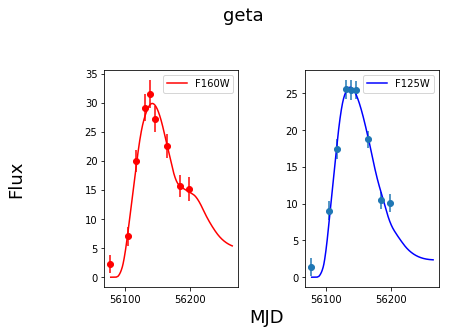

In [8]:
# To append the result,fitted model, data too
lightcurve_model = []

# CLP12Get; geta starudust 1.0 probability of Ia
i = 9
tab = clashlc[i]
name = clashlc[i].meta['NICKNAME'][0]
print(name)
model = sncosmo.Model(source='salt2')
lightcurve_model.append(tab)

# Only fit to these bands
dat = copy.copy(tab)
tmp = list(np.arange(len(dat)))
for i in range(len(dat)):
    if dat[i]['band'] == 'F160W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F125W':
        tmp.remove(i)
    else: continue
dat.remove_rows(tmp)

# using initial redshift and bounds from previous fits available in table
try:
    z = np.float(tab.meta['REDSHIFT_FINAL'][0])
    dz = np.float(tab.meta['REDSHIFT_FINAL'][2])
    zup = z + dz
    zlow = z - dz
except:
    pass

# include the dust extinction for lights path through milky way
model.add_effect(sncosmo.CCM89Dust(),'mw','obs')
try:
    ebv = np.float(tab.meta['MWEBV'][0])
    model.set(mwebv = ebv)
    print(i,'including dust')
except: pass

# try to fit model
try:
    result,fitted_model=sncosmo.fit_lc(
        dat ,model,
        ['z', 't0', 'x0', 'x1', 'c'],
        bounds={'z':(zlow,zup)})
    print('success')
except:
    [result,fitted_model] = ['failed','failed'] 
    print('failed')
    
# put results and fitted_model into list object with astropy table of data 
lightcurve_model.append([result,fitted_model])
    

# Remaining is just plotting... using model to display the fit w data
# need the f160w and f125w data points/error bars to plot with model  
f160w = []
f125w = []
for i in dat:
    if i['band'] == 'F160W':
        f160w.append(i)
    elif i['band'] == 'F125W':
        f125w.append(i)
    else: print('not f125 or f160? should only have these remaining')
from astropy.table import vstack
f160w = vstack([i for i in  f160w])
f125w = vstack([i for i in f125w])
flux_f160w = [i for i in f160w['flux']] 
flux_f125w = [i for i in f125w['flux']]
dflux_f160w = [i for i in  f160w['fluxerr']]
dflux_f125w = [i for i in f125w['fluxerr']]
t160w = [i for i in f160w['time']]
t125w = [i for i in f125w['time']]


z = fitted_model.parameters[0]
t0 = fitted_model.parameters[1]
x1 = fitted_model.parameters[2]
x2 = fitted_model.parameters[3]
c = fitted_model.parameters[4]

# may need to play with these to get plot looking good for each different case
t = np.linspace(t0 - 60,t0+125,10000)
fig, (ax1,ax2) = plt.subplots(1,2)
fig.text(0.5, 0.001, 'MJD', ha='center',size=18)
fig.text(-0.1, 0.5, 'Flux', va='center', rotation='vertical',size=18)
#txtstr = 'z =' + str(z)[:4] + '\n' 't0 = '+ str(t0)[:7] + '\n' + 'A = '+ str(np.format_float_scientific(A,precision=2))
#fig.text(.5,1.10,txtstr,va='center',size=18)

fig.text(0.4,1.05,name,size=18)


ax1.plot(t,fitted_model.bandflux('F160W',t,zp=27.5,zpsys='VEGA'),label='F160W',color = 'red')
ax1.errorbar(t160w,flux_f160w,yerr = dflux_f160w,fmt='o',color='red')

ax2.plot(t,fitted_model.bandflux('F125W',t,zp=27.5,zpsys='VEGA'),label='F125W',color='blue')
ax2.errorbar(t125w,flux_f125w,yerr=dflux_f125w,fmt='o')

plt.subplots_adjust(wspace=0.5)
ax1.legend()
ax2.legend()

# saves jpeg
#img_jpeg = plt.savefig(name,bbox_inches='tight')
# dumps the fig into pickle; nice if want to play with figure later
# img_pkl = pickle.dump(fig, open(name+'.pkl', 'wb'))
# %matplotlib notebook
# load_img_pkl = pickle.load( open( "CLA10Cal.pkl", "rb" ) )

pickle.dump(lightcurve_model,open('results/clashIa_sansfig/'+name+'sansfig.pkl','wb'))


# include an image with the data table, result, fit 
lightcurve_model.append(fig)

pickle.dump(lightcurve_model,open(name+'.pkl','wb'))
# view in another notebook = pickle.load(open('CLA10Cal.pkl','rb'))

rose
5 including dust
success


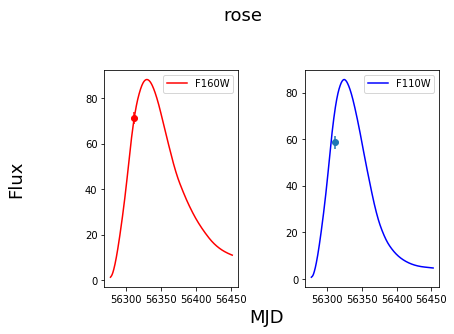

In [9]:
# To append the result,fitted model, data too
lightcurve_model = []

# rose couldnt find any literature on this one will assume Ia
i = 13
tab = clashlc[i]
name = clashlc[i].meta['NICKNAME'][0]
print(name)
model = sncosmo.Model(source='salt2')
lightcurve_model.append(tab)

# Only fit to these bands
dat = copy.copy(tab)
tmp = list(np.arange(len(dat)))
for i in range(len(dat)):
    if dat[i]['band'] == 'F160W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F110W':
        tmp.remove(i)
    else: continue
dat.remove_rows(tmp)

# using initial redshift and bounds from previous fits available in table
try:
    z = np.float(tab.meta['REDSHIFT_FINAL'][0])
    dz = np.float(tab.meta['REDSHIFT_FINAL'][2])
    zup = z + dz
    zlow = z - dz
except:
    pass

# include the dust extinction for lights path through milky way
model.add_effect(sncosmo.CCM89Dust(),'mw','obs')
try:
    ebv = np.float(tab.meta['MWEBV'][0])
    model.set(mwebv = ebv)
    print(i,'including dust')
except: pass

# try to fit model
try:
    result,fitted_model=sncosmo.fit_lc(
        dat ,model,
        ['z', 't0', 'x0', 'x1', 'c'],
        bounds={'z':(zlow,zup)})
    print('success')
except:
    [result,fitted_model] = ['failed','failed'] 
    print('failed')
    
# put results and fitted_model into list object with astropy table of data 
lightcurve_model.append([result,fitted_model])
    

# Remaining is just plotting... using model to display the fit w data
# need the f160w and f125w data points/error bars to plot with model  
f160w = []
f110w = []
for i in dat:
    if i['band'] == 'F160W':
        f160w.append(i)
    elif i['band'] == 'F110W':
        f110w.append(i)
    else: print('not f125 or f160? should only have these remaining')
from astropy.table import vstack
f160w = vstack([i for i in  f160w])
f110w = vstack([i for i in f110w])
flux_f160w = [i for i in f160w['flux']] 
flux_f110w = [i for i in f110w['flux']]
dflux_f160w = [i for i in  f160w['fluxerr']]
dflux_f110w = [i for i in f110w['fluxerr']]
t160w = [i for i in f160w['time']]
t110w = [i for i in f110w['time']]


z = fitted_model.parameters[0]
t0 = fitted_model.parameters[1]
x1 = fitted_model.parameters[2]
x2 = fitted_model.parameters[3]
c = fitted_model.parameters[4]

# may need to play with these to get plot looking good for each different case
t = np.linspace(t0 - 50,t0+125,10000)
fig, (ax1,ax2) = plt.subplots(1,2)
fig.text(0.5, 0.001, 'MJD', ha='center',size=18)
fig.text(-0.1, 0.5, 'Flux', va='center', rotation='vertical',size=18)
#txtstr = 'z =' + str(z)[:4] + '\n' 't0 = '+ str(t0)[:7] + '\n' + 'A = '+ str(np.format_float_scientific(A,precision=2))
#fig.text(.5,1.10,txtstr,va='center',size=18)

fig.text(0.4,1.05,name,size=18)


ax1.plot(t,fitted_model.bandflux('F160W',t,zp=27.5,zpsys='VEGA'),label='F160W',color = 'red')
ax1.errorbar(t160w,flux_f160w,yerr = dflux_f160w,fmt='o',color='red')

ax2.plot(t,fitted_model.bandflux('F125W',t,zp=27.5,zpsys='VEGA'),label='F110W',color='blue')
ax2.errorbar(t110w,flux_f110w,yerr=dflux_f110w,fmt='o')

plt.subplots_adjust(wspace=0.5)
ax1.legend()
ax2.legend()

# saves jpeg
#img_jpeg = plt.savefig(name,bbox_inches='tight')
# dumps the fig into pickle; nice if want to play with figure later
# img_pkl = pickle.dump(fig, open(name+'.pkl', 'wb'))
# %matplotlib notebook
# load_img_pkl = pickle.load( open( "CLA10Cal.pkl", "rb" ) )

pickle.dump(lightcurve_model,open('results/clashIa_sansfig/'+name+'sansfig.pkl','wb'))

# include an image with the data table, result, fit 
lightcurve_model.append(fig)

pickle.dump(lightcurve_model,open(name+'.pkl','wb'))
# view in another notebook = pickle.load(open('CLA10Cal.pkl','rb'))

Tiberius
17 including dust
success


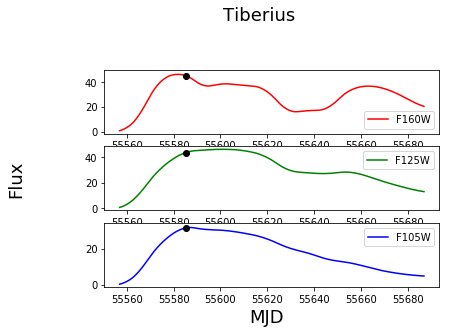

In [10]:
# To append the result,fitted model, data too
lightcurve_model = []

# tiberius; didius Ia
i = 14
tab = clashlc[i]
name = clashlc[i].meta['NICKNAME'][0]
print(name)
model = sncosmo.Model(source='salt2')
lightcurve_model.append(tab)

# Only fit to these nir bands
dat = copy.copy(tab)

tmp = list(np.arange(len(dat)))
for i in range(len(dat)):
    if dat[i]['band'] == 'F160W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F125W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F105W':
        tmp.remove(i)
    else: continue
dat.remove_rows(tmp)

# using initial redshift and bounds from previous fits available in table
try:
    z = np.float(tab.meta['REDSHIFT_FINAL'][0])
    dz = np.float(tab.meta['REDSHIFT_FINAL'][2])
    zup = z + dz
    zlow = z - dz
except:
    pass

# include the dust extinction for lights path through milky way
model.add_effect(sncosmo.CCM89Dust(),'mw','obs')
try:
    ebv = np.float(tab.meta['MWEBV'][0])
    model.set(mwebv = ebv)
    print(i,'including dust')
except: pass

# try to fit model
try:
    result,fitted_model=sncosmo.fit_lc(
        dat ,model,
        ['z', 't0', 'x0', 'x1', 'c'],
        bounds={'z':(zlow,zup)})
    print('success')
except:
    [result,fitted_model] = ['failed','failed'] 
    print('failed')
    
# put results and fitted_model into list object with astropy table of data 
lightcurve_model.append([result,fitted_model])
    

# Remaining is just plotting... using model to display the fit w data
# need the nir data points/error bars to plot with model  
f160w = []
f125w = []
f105w = []
for i in dat:
    if i['band'] == 'F160W':
        f160w.append(i)
    elif i['band'] == 'F125W':
        f125w.append(i)
    elif i['band'] == 'F105W':
        f105w.append(i)
    else: print('not one of the bands that should be remaining')

from astropy.table import vstack
f160w = vstack([i for i in  f160w])
f125w = vstack([i for i in f125w])
f105w = vstack([i for i in f105w])

flux_f160w = [i for i in f160w['flux']] 
flux_f125w = [i for i in f125w['flux']]
flux_f105w = [i for i in f105w['flux']]


dflux_f160w = [i for i in  f160w['fluxerr']]
dflux_f125w = [i for i in f125w['fluxerr']]
dflux_f105w = [i for i in f105w['fluxerr']]

t160w = [i for i in f160w['time']]
t125w = [i for i in f125w['time']]
t105w = [i for i in f105w['time']]


z = fitted_model.parameters[0]
t0 = fitted_model.parameters[1]
x1 = fitted_model.parameters[2]
x2 = fitted_model.parameters[3]
c = fitted_model.parameters[4]

# may need to play with time to get plot looking good for each different case
t = np.linspace(t0 - 40,t0+90,10000)

fig, axes = plt.subplots(3,1)
fig.text(0.5, 0.001, 'MJD', ha='center',size=18)
fig.text(-0.1, 0.5, 'Flux', va='center', rotation='vertical',size=18)
#txtstr = 'z =' + str(z)[:4] + '\n' 't0 = '+ str(t0)[:7] + '\n' + 'A = '+ str(np.format_float_scientific(A,precision=2))
#fig.text(.5,1.10,txtstr,va='center',size=18)

fig.text(0.4,1.05,name,size=18)


axes[0].plot(t,fitted_model.bandflux('F160W',t,zp=27.5,zpsys='VEGA'),label='F160W',color = 'red')
axes[0].errorbar(t160w,flux_f160w,yerr = dflux_f160w,fmt='o',color='black')

axes[1].plot(t,fitted_model.bandflux('F125W',t,zp=27.5,zpsys='VEGA'),label='F125W',color='green')
axes[1].errorbar(t125w,flux_f125w,yerr=dflux_f125w,fmt='o',color='black')

axes[2].plot(t,fitted_model.bandflux('F105W',t,zp=27.5,zpsys='VEGA'),label='F105W',color='blue')
axes[2].errorbar(t105w,flux_f105w,yerr=dflux_f105w,fmt='o',color='black')



plt.subplots_adjust(wspace=0.5)
axes[0].legend()
axes[1].legend()
axes[2].legend()
# saves jpeg
#img_jpeg = plt.savefig(name,bbox_inches='tight')
# dumps the fig into pickle; nice if want to play with figure later
# img_pkl = pickle.dump(fig, open(name+'.pkl', 'wb'))
# %matplotlib notebook
# load_img_pkl = pickle.load( open( "CLA10Cal.pkl", "rb" ) )

pickle.dump(lightcurve_model,open('results/clashIa_sansfig/'+name+'sansfig.pkl','wb'))


# include an image with the data table, result, fit 
lightcurve_model.append(fig)

pickle.dump(lightcurve_model,open(name+'.pkl','wb'))
# view in another notebook = pickle.load(open('name.pkl','rb'))